This Colab notebook aims to provide a comprehensive understanding of transfer learning, including its underlying principles and its widespread application in image classification and object detection tasks.

## Transfer Learning
Transfer learning is a paradigm in deep learning where knowledge gained from solving one problem is leveraged to address a related, often more specific, task. In neural network applications, this typically involves initializing a model with weights from a network previously trained on a large-scale dataset, rather than starting with random weights. This approach benefits from the rich feature representations learned during the initial training phase, enabling faster convergence and improved performance—especially when the new task has limited data.

For more detais- https://cs231n.github.io/transfer-learning/

### Steps to run the colab notebook.
1. Change th eruntime configuration from CPU to T4 GPU.

In [1]:
## Importing the required libraries.
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torch.utils.data import DataLoader
import time
from torchvision import datasets
import copy
from tempfile import TemporaryDirectory
import os, zipfile, pathlib, random
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Extract the data. For this colab notebook task, we will be using the bee and ants image dataset.
Link: https://download.pytorch.org/tutorial/hymenoptera_data.zip
We have about 120 training images each for ants and bees. There are 75 validation images for each class.

In [2]:
## Download and extract
data_root = "/content/data"
os.makedirs(data_root, exist_ok=True)

zip_url = "https://download.pytorch.org/tutorial/hymenoptera_data.zip"
zip_path = f"{data_root}/hymenoptera_data.zip"

# download
!wget -q -O "$zip_path" "$zip_url"

# extract
with zipfile.ZipFile(zip_path, 'r') as zf:
    zf.extractall(data_root)

# dataset directory (contains train/val subfolders)
data_dir = f"{data_root}/hymenoptera_data"
print("Extracted to:", data_dir)
print("Subdirs:", os.listdir(data_dir))


Extracted to: /content/data/hymenoptera_data
Subdirs: ['train', 'val']



[TRAIN]
  ants: 124 images
  bees: 121 images

[VAL]
  ants: 70 images
  bees: 83 images


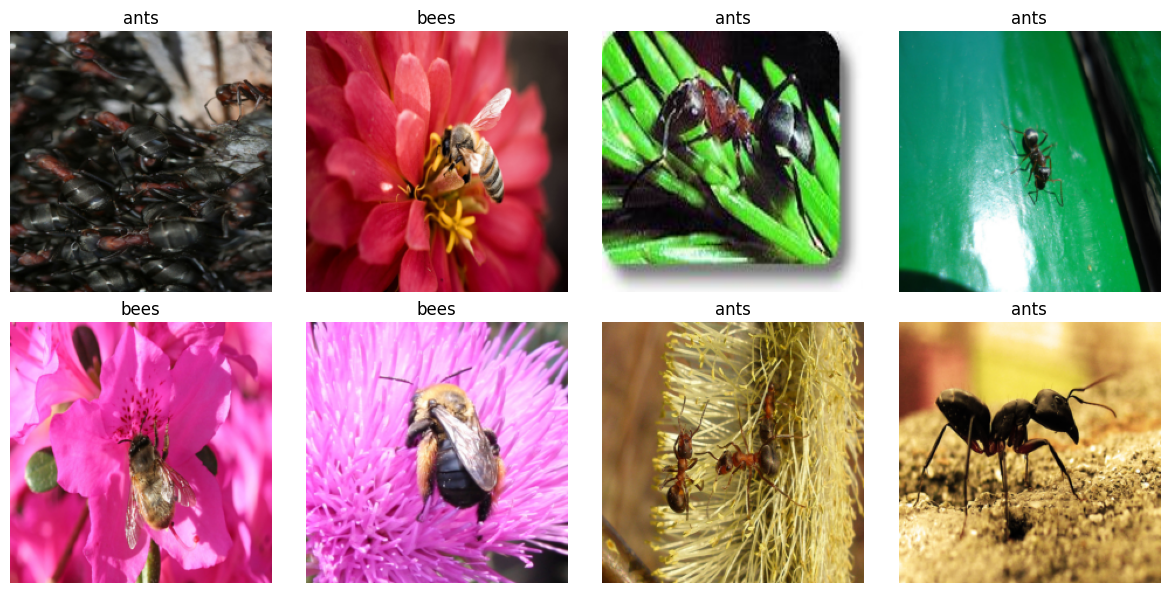

In [9]:
## Count the number of images in each set
for split in ["train", "val"]:
    split_dir = pathlib.Path(data_dir) / split
    print(f"\n[{split.upper()}]")
    for cls in sorted(os.listdir(split_dir)):
        cls_dir = split_dir / cls
        n = len(list(cls_dir.glob("*")))
        print(f"  {cls}: {n} images")


# ========================
# Load and visualize dataset
# ========================
# Define transform for visualization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}


# Load training dataset
dataset = datasets.ImageFolder(os.path.join(data_dir, "train"), transform=transform)
class_names = dataset.classes

# Function to show images
def show_images(dataset, class_names, num_images=8):
    import random
    indices = random.sample(range(len(dataset)), num_images)
    plt.figure(figsize=(12, 6))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        img = img.permute(1, 2, 0)
        plt.subplot(2, 4, i+1)
        plt.imshow(img)
        plt.title(class_names[label])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show images
show_images(dataset, class_names)

In [21]:
import time
from tempfile import TemporaryDirectory
import torch

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, scheduler, device, num_epochs=25):
    since = time.time()
    history = {'train_acc': [], 'val_acc': [], 'train_loss': [], 'val_loss': []}

    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()
                else:
                    model.eval()

                running_loss = 0.0
                running_corrects = 0

                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()

                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                history[f'{phase}_loss'].append(epoch_loss)
                history[f'{phase}_acc'].append(epoch_acc.item())

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:.4f}')

        model.load_state_dict(torch.load(best_model_params_path))

    return model, history



image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), transform=data_transforms[x])
    for x in ['train', 'val']
}

# Create dataloaders
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=8, shuffle=True, num_workers=2)
    for x in ['train', 'val']
}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
print(50*"==")
print(dataset_sizes)
print(50*"==")

{'train': 244, 'val': 153}


In [22]:
model_scratch = models.resnet18(pretrained=False)
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = nn.Linear(num_ftrs, len(class_names))  # Adapt final layer to match num classes
model_scratch = model_scratch.to(device)

# Use the same loss function
criterion = nn.CrossEntropyLoss()

# Train all parameters (no freezing)
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
scheduler_scratch = optim.lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

# Train the model from scratch
print("🛠️ Training ResNet18 from scratch...\n")
model_scratch, history_scratch = train_model(model_scratch, dataloaders, dataset_sizes, criterion, optimizer_scratch, scheduler_scratch, device, num_epochs=10)

🛠️ Training ResNet18 from scratch...

Epoch 0/9
----------
train Loss: 0.6965 Acc: 0.5615
val Loss: 0.7303 Acc: 0.4510

Epoch 1/9
----------
train Loss: 0.6521 Acc: 0.6516
val Loss: 0.6643 Acc: 0.5882

Epoch 2/9
----------
train Loss: 0.6301 Acc: 0.6352
val Loss: 0.6283 Acc: 0.6471

Epoch 3/9
----------
train Loss: 0.6495 Acc: 0.6639
val Loss: 1.1105 Acc: 0.6078

Epoch 4/9
----------
train Loss: 0.6420 Acc: 0.6598
val Loss: 0.6064 Acc: 0.6536

Epoch 5/9
----------
train Loss: 0.6005 Acc: 0.6803
val Loss: 0.7908 Acc: 0.6732

Epoch 6/9
----------
train Loss: 0.5788 Acc: 0.7090
val Loss: 0.6372 Acc: 0.6928

Epoch 7/9
----------
train Loss: 0.5143 Acc: 0.7459
val Loss: 0.6532 Acc: 0.6797

Epoch 8/9
----------
train Loss: 0.4758 Acc: 0.7500
val Loss: 0.6114 Acc: 0.6797

Epoch 9/9
----------
train Loss: 0.4983 Acc: 0.7664
val Loss: 0.5978 Acc: 0.6993

Training complete in 0m 26s
Best val Acc: 0.6993


ResNET18 with Transfer Learning

In [24]:
# Load pretrained model
model_tl = models.resnet18(pretrained=True)
num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, len(class_names))
model_tl = model_tl.to(device)
criterion = nn.CrossEntropyLoss()
# Freeze all layers except final fc
for param in model_tl.parameters():
    param.requires_grad = False
for param in model_tl.fc.parameters():
    param.requires_grad = True

optimizer_tl = optim.SGD(model_tl.fc.parameters(), lr=0.001, momentum=0.9)
scheduler_tl = optim.lr_scheduler.StepLR(optimizer_tl, step_size=7, gamma=0.1)

print("🔧 Training ResNet18 with transfer learning...\n")
model_tl, history_tl = train_model(model_tl, dataloaders, dataset_sizes, criterion, optimizer_tl, scheduler_tl, device, num_epochs=10)


🔧 Training ResNet18 with transfer learning...

Epoch 0/9
----------
train Loss: 0.6565 Acc: 0.6762
val Loss: 0.3464 Acc: 0.8562

Epoch 1/9
----------
train Loss: 0.3318 Acc: 0.8648
val Loss: 0.2529 Acc: 0.8824

Epoch 2/9
----------
train Loss: 0.2431 Acc: 0.8852
val Loss: 0.2157 Acc: 0.9150

Epoch 3/9
----------
train Loss: 0.2244 Acc: 0.9098
val Loss: 0.2149 Acc: 0.9150

Epoch 4/9
----------
train Loss: 0.2268 Acc: 0.9139
val Loss: 0.1935 Acc: 0.9216

Epoch 5/9
----------
train Loss: 0.2354 Acc: 0.9057
val Loss: 0.1984 Acc: 0.9281

Epoch 6/9
----------
train Loss: 0.2988 Acc: 0.8689
val Loss: 0.1989 Acc: 0.9346

Epoch 7/9
----------
train Loss: 0.1719 Acc: 0.9221
val Loss: 0.2112 Acc: 0.9150

Epoch 8/9
----------
train Loss: 0.1868 Acc: 0.9344
val Loss: 0.1998 Acc: 0.9216

Epoch 9/9
----------
train Loss: 0.1907 Acc: 0.9098
val Loss: 0.2146 Acc: 0.9085

Training complete in 0m 25s
Best val Acc: 0.9346


## Plot the accuracy

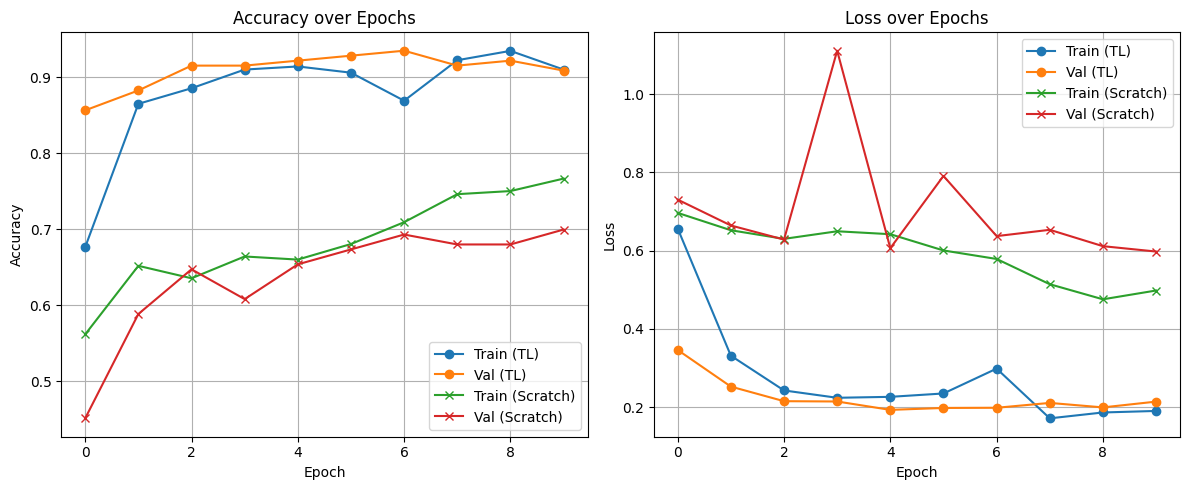

In [25]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_tl['train_acc'], label='Train (TL)', marker='o')
plt.plot(history_tl['val_acc'], label='Val (TL)', marker='o')
plt.plot(history_scratch['train_acc'], label='Train (Scratch)', marker='x')
plt.plot(history_scratch['val_acc'], label='Val (Scratch)', marker='x')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_tl['train_loss'], label='Train (TL)', marker='o')
plt.plot(history_tl['val_loss'], label='Val (TL)', marker='o')
plt.plot(history_scratch['train_loss'], label='Train (Scratch)', marker='x')
plt.plot(history_scratch['val_loss'], label='Val (Scratch)', marker='x')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()